# Data Encoding

In the following notebook, we follow the IBM Course `Quantum Machine Learning`, and in particular discuss several ways of data encoding in quantum machine learning.

## Basis encoding

Basis encoding encodes classical P-bit strings into the computational state of a P-qubit system. As an example, let's encode the vector (5,7,0). The binary strings are given by
* 5 $\to$ 0101
* 7 $\to$ 0111
* 0 $\to$ 0000

and its 12-qubit quantum state is given by $|010101110000\rangle$. The code below converts the data vector (5,7,0) to a quantum state, and is generalized to do so for other single-digit features.

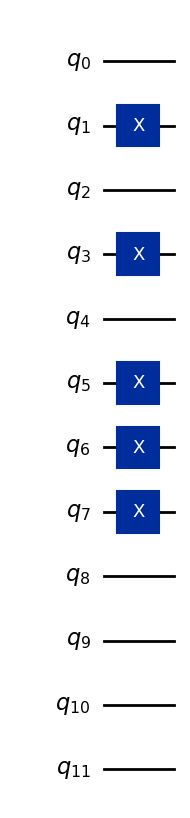

In [1]:
from qiskit import QuantumCircuit
 
# Data point to encode
x = 5  # binary: 0101
y = 7  # binary: 0111
z = 0  # binary: 0000
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,1]
y_bits = [int(b) for b in format(y, "04b")]  # [0,1,1,1]
z_bits = [int(b) for b in format(z, "04b")]  # [0,0,0,0]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,1,0,1,1,1,0,0,0,0]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

For the vector (4,8,5) this would be

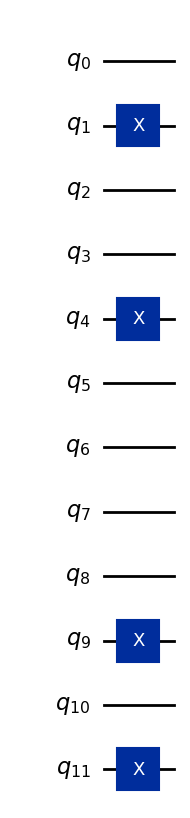

In [2]:
# Data point to encode
x = 4  # binary: 0100
y = 8  # binary: 1000
z = 5  # binary: 0101
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,0]
y_bits = [int(b) for b in format(y, "04b")]  # [1,0,0,0]
z_bits = [int(b) for b in format(z, "04b")]  # [0,1,0,1]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,0,1,0,0,0,0,1,0,1]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

## Amplitude encoding

Another method is amplitude encoding, where an N-dimensional data vector $\vec{x}^{(j)}$ is encoded as an amplitude of a n-qubit quantum state $|\psi_x\rangle$ as
\begin{equation}
|\psi_x^{(j)}\rangle = \frac{1}{\alpha}\sum_{i=1}^{N} x_i^{(j)}|i\rangle
\end{equation}
where $x_i^{(j)}$ is the $i^{\rm th}$ element of $\vec{x}^{(j)}$, $|i\rangle$ is the $i^{\rm th}$ computational basis state, $\alpha$ the normalization calculated by $\sum_{i=1}^N |x_i^{(j)}|^2=\alpha^2$. We need $n \geq \log_2(N)$ qubits for $|i\rangle$.

Let's look at the example $\vec{x}^{(1)}=(4,8,5)$ which becomes
\begin{equation}
|\psi (\vec{x}^{(1)}\rangle = \frac{1}{\sqrt{105}} (4|00\rangle + 8 |01\rangle +5|10\rangle +0 |11\rangle)
\end{equation}

In Qiskit this state can be prepared as:

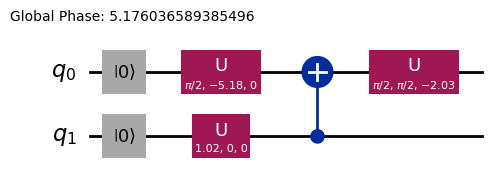

In [6]:
import math
 
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]
 
qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])
 
qc.decompose(reps=5).draw(output="mpl")

As a second example, we look at $\vec{x}=(9,8,6,2,9,2)$. The normalization is $\alpha=\sqrt{270}$ and $n\geq \log_2(6) \approx 2.58$, so we need $n=3$ qubits. Hence, we get
\begin{equation}
|\psi(\vec{x})\rangle = \frac{1}{\sqrt{270}}(9|000\rangle + 8 |001\rangle + 6|010\rangle + 2|011\rangle + 9 |100\rangle + 2|101\rangle + 0 |110\rangle + 0|111\rangle)
\end{equation}

The coded version would be

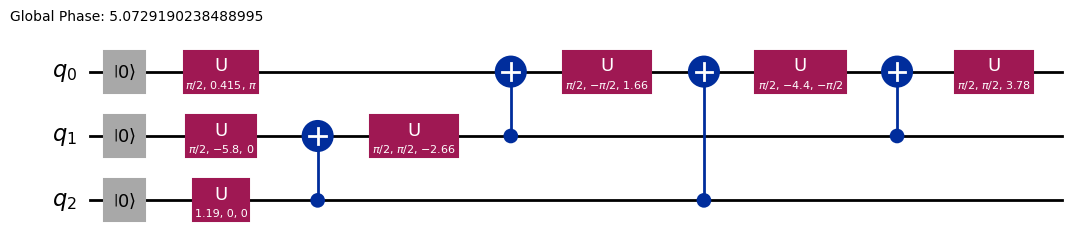

In [11]:
desired_state = [
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 8,
    1 / math.sqrt(270) * 6,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 0,
    1 / math.sqrt(270) * 0,
]
 
qc = QuantumCircuit(3)
qc.initialize(desired_state, [0, 1, 2])
 
qc.decompose(reps=8).draw(output="mpl")

While this case was still possible by hand, we would like to automate the process of amplitude encoding. In the following, we will write some functions to automatically initialize amplitude encoded states.

In [29]:
def norm(vec):
    alpha = sum([i**2 for i in vec])
    return math.sqrt(alpha)

def calc_n(vec):
    nr_entries = len(vec)
    n = math.ceil(math.log(nr_entries, 2))
    return n

def desired_state(vec):
    fac = 1/norm(vec)
    state = [fac*i for i in vec]
    nr_basis_states = 2**calc_n(vec)
    if len(state)<nr_basis_states:
        for ix in range(len(state),nr_basis_states):
            state.append(0)
    return state

def run_encoding(vector,reps):
    state = desired_state(vector)
    n = calc_n(vector)
    q_list = list(range(n))
    
    qc = QuantumCircuit(n)
    qc.initialize(state, q_list)
 
    return qc.decompose(reps=reps).draw(output="mpl")

As an example, let's take $\vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$:

4


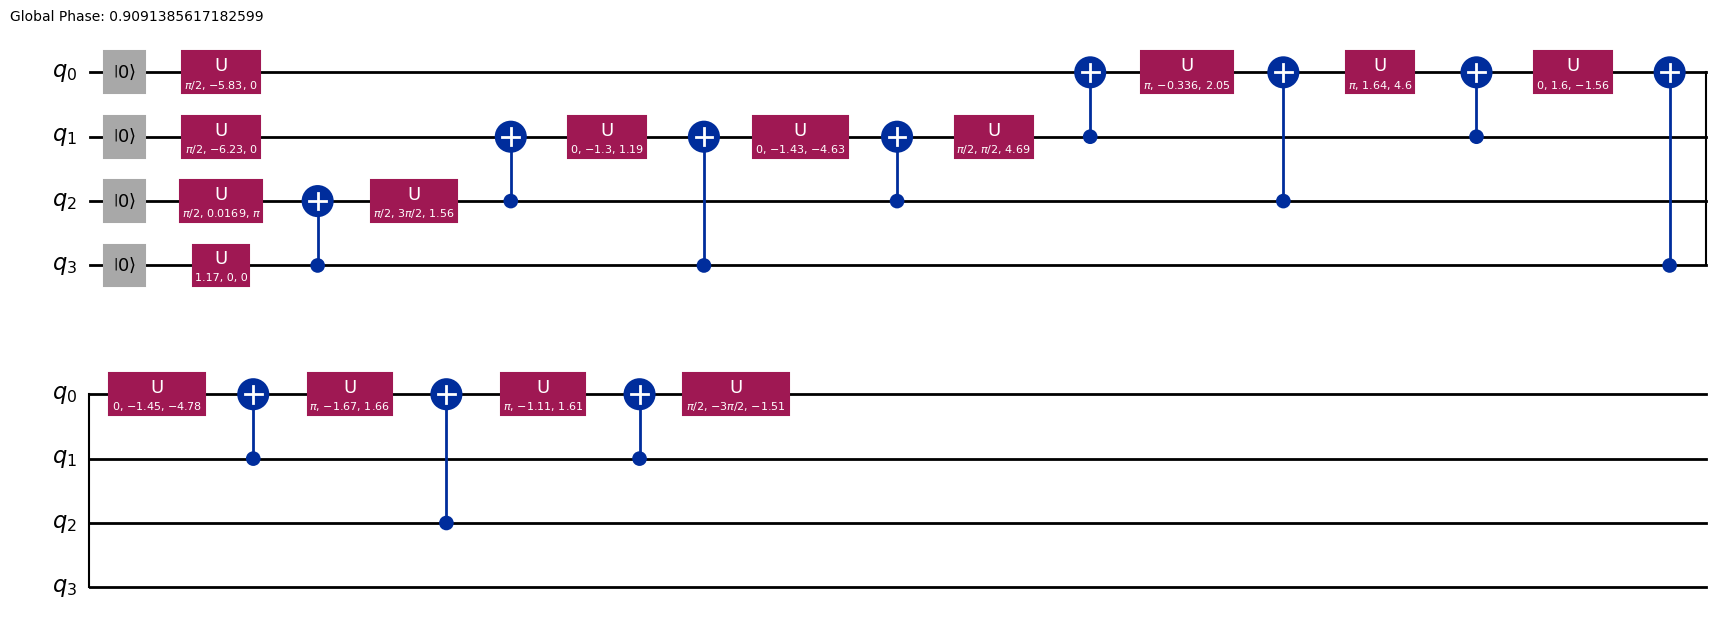

In [32]:
vector = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]

print(calc_n(vector))
state = desired_state(vector)

run_encoding(state,16)